In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from data_loader import create_dataloaders
from feature_extractor_finetuned import extract_and_stack_features_finetuned, save_features, load_features
from feature_selector import select_features_ensemble
from models import MetaLearnerMLP
import os

class FinetunedTrainer:
    """
    Train meta-learner using features extracted from FINE-TUNED models
    (not frozen pretrained ImageNet models)
    """
    def __init__(self, data_dir, batch_size=32, device='cuda', feature_ratio=0.5,
                 xception_ckpt='../baseline/xception_Dataset_best.pth',
                 efficientnet_ckpt='../baseline/efficientnet_b3_Dataset_best.pth'):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.device = device
        self.feature_ratio = feature_ratio
        self.xception_ckpt = xception_ckpt
        self.efficientnet_ckpt = efficientnet_ckpt
        self.feature_dir = 'features_finetuned'
        os.makedirs(self.feature_dir, exist_ok=True)
        
    def extract_train_features(self):
        train_path = f'{self.feature_dir}/train_features.npz'
        if os.path.exists(train_path):
            print(f"Loading cached features from {train_path}")
            X_train, y_train = load_features(train_path)
        else:
            train_loader, _, _ = create_dataloaders(self.data_dir, self.batch_size, img_size=224, num_workers=4)
            X_train, y_train = extract_and_stack_features_finetuned(
                train_loader, self.device, 
                self.xception_ckpt, self.efficientnet_ckpt
            )
            save_features(X_train, y_train, train_path)
        return X_train, y_train
    
    def extract_eval_features(self, split):
        path = f'{self.feature_dir}/{split}_features.npz'
        if os.path.exists(path):
            print(f"Loading cached features from {path}")
            return load_features(path)
        _, val_loader, test_loader = create_dataloaders(self.data_dir, self.batch_size, img_size=224, num_workers=4)
        loader = val_loader if split == 'val' else test_loader
        X, y = extract_and_stack_features_finetuned(
            loader, self.device,
            self.xception_ckpt, self.efficientnet_ckpt
        )
        save_features(X, y, path)
        return X, y
    
    def train_meta_learner(self, X_train, y_train, X_val, y_val, epochs=100, lr=0.001, batch_size=512):
        input_dim = X_train.shape[1]
        model = MetaLearnerMLP(input_dim=input_dim).to(self.device)
        criterion = nn.CrossEntropyLoss()
        
        # SGD with momentum: ổn định và hiệu quả cho classification
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4, nesterov=True)
        
        # OneCycleLR: tăng lr lên max rồi giảm dần (hội tụ nhanh)
        steps_per_epoch = (len(X_train) + batch_size - 1) // batch_size
        total_steps = steps_per_epoch * epochs
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=lr,
            total_steps=total_steps,
            pct_start=0.3,
            anneal_strategy='cos'
        )
        
        # Create DataLoader cho mini-batch training
        from torch.utils.data import TensorDataset, DataLoader
        train_dataset = TensorDataset(
            torch.FloatTensor(X_train),
            torch.LongTensor(y_train)
        )
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )
        
        X_val_tensor = torch.FloatTensor(X_val).to(self.device)
        y_val_tensor = torch.LongTensor(y_val).to(self.device)
        
        best_val_acc = 0
        best_model_state = None
        
        for epoch in range(epochs):
            # Training với mini-batches
            model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                scheduler.step()  # OneCycleLR step mỗi batch
                
                train_loss += loss.item() * X_batch.size(0)
            
            train_loss /= len(X_train)
            
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor)
                val_preds = val_outputs.argmax(dim=1).cpu().numpy()
                val_acc = accuracy_score(y_val, val_preds)
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model_state = model.state_dict().copy()
                
                if (epoch + 1) % 5 == 0:
                    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss.item():.4f} - Val Acc: {val_acc:.4f} - Best: {best_val_acc:.4f}')
        
        print(f"\nBest validation accuracy: {best_val_acc:.4f}")
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        return model
    
    def evaluate(self, model, X_test, y_test):
        model.eval()
        X_test_tensor = torch.FloatTensor(X_test).to(self.device)
        
        with torch.no_grad():
            outputs = model(X_test_tensor)
            probs = torch.softmax(outputs, dim=1)[:, 1]
        
        thresh=0.4
        preds = (probs.cpu().numpy() > thresh).astype(int)
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds)
        rec = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        
        print(f'\nTest Results (Fine-tuned Features):')
        print(f'Accuracy:  {acc:.4f}')
        print(f'Precision: {prec:.4f}')
        print(f'Recall:    {rec:.4f}')
        print(f'F1-Score:  {f1:.4f}')
        
        # Confusion Matrix
        from sklearn.metrics import confusion_matrix
        import matplotlib.pyplot as plt
        cm = confusion_matrix(y_test, preds)
        
        plt.figure(figsize=(6, 5))
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
        plt.colorbar()
        
        classes = ['Real', 'Fake']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, fontsize=12)
        plt.yticks(tick_marks, classes, fontsize=12)
        
        # Thêm số vào từng ô
        thresh_cm = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontsize=14,
                    color="white" if cm[i, j] > thresh_cm else "black")
        
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        return acc, prec, rec, f1
    
    def run(self):
        from sklearn.preprocessing import StandardScaler
        
        print("\nStep 1: Extract Train Features from Fine-tuned Models")
        X_train, y_train = self.extract_train_features()
        print(f"Train: {X_train.shape}")
        
        print("\nStep 2: Normalize Features")
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        
        print("\nStep 3: Extract Val Features")
        X_val, y_val = self.extract_eval_features('val')
        X_val = scaler.transform(X_val)
        print(f"Val: {X_val.shape}")
        
        print("\nStep 4: Feature Selection (XGBoost)")
        from xgboost import XGBClassifier
        k_features = int(X_train.shape[1] * self.feature_ratio)
        print(f"Selecting top {k_features} features ({self.feature_ratio*100:.0f}%)")
        xgb = XGBClassifier(
            n_estimators=200, 
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42, 
            tree_method='hist', 
            device='cuda'
        )
        xgb.fit(X_train, y_train)
        indices = np.argsort(xgb.feature_importances_)[::-1][:k_features]
        X_train_sel = X_train[:, indices]
        X_val_sel = X_val[:, indices]
        print(f"Selected: {X_train_sel.shape}")
        
        print("\nStep 5: Train Meta-Learner MLP (SGD + OneCycleLR)")
        model = self.train_meta_learner(X_train_sel, y_train, X_val_sel, y_val, epochs=50, lr=0.0001, batch_size=512)
        
        # Save ensemble model
        print("\nSaving ensemble model...")
        save_path = 'ensemble_finetuned_best.pth'
        torch.save({
            'model_state_dict': model.state_dict(),
            'scaler': scaler,
            'selected_indices': indices,
            'input_dim': X_train_sel.shape[1],
            'feature_ratio': self.feature_ratio,
            'xception_ckpt': self.xception_ckpt,
            'efficientnet_ckpt': self.efficientnet_ckpt
        }, save_path)
        print(f"Saved to {save_path}")
        
        print("\nStep 6: Load ensemble model and Evaluate on Test Set")
        checkpoint = torch.load(save_path, map_location=self.device, weights_only=False)
        
        model = MetaLearnerMLP(input_dim=checkpoint['input_dim']).to(self.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        scaler = checkpoint['scaler']
        indices = checkpoint['selected_indices']
        print("Model + Scaler + Feature Indices loaded!")
        # Đo thời gian test
        test_start_time = time.time()
        X_test, y_test = self.extract_eval_features('test')
        
        X_test = scaler.transform(X_test)
        X_test_sel = X_test[:, indices]
        print(f"Test: {X_test_sel.shape}")
        
        
        test_acc, prec, rec, f1 = self.evaluate(model, X_test_sel, y_test)
        test_time = time.time() - test_start_time
        
        # Hiển thị thời gian test
        print(f"Test Time: {test_time:.2f}s ({len(y_test)/test_time:.1f} samples/s)")
        
        # Lưu test metrics + time vào checkpoint
        checkpoint['test_acc'] = test_acc
        checkpoint['test_precision'] = prec
        checkpoint['test_recall'] = rec
        checkpoint['test_f1'] = f1
        checkpoint['test_time'] = test_time
        torch.save(checkpoint, save_path)
        print(f"Updated {save_path} with test metrics and time")
        
if __name__ == '__main__':
    trainer = FinetunedTrainer(
        data_dir='../Dataset',
        batch_size=64,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        feature_ratio=0.4,  
        xception_ckpt='../baseline/xception_Dataset_best.pth',
        efficientnet_ckpt='../baseline/efficientnet_b3_Dataset_best.pth'
    )
    trainer.run()


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded fine-tuned Xception from ../baseline/xception_Dataset_best.pth
  - Num features: 2048
Loaded fine-tuned EfficientNet-B3 from ../baseline/efficientnet_b3_Dataset_best.pth
  - Num features: 1536
Loaded fine-tuned EfficientNet-B3 from ../baseline/efficientnet_b3_Dataset_best.pth
  - Num features: 1536


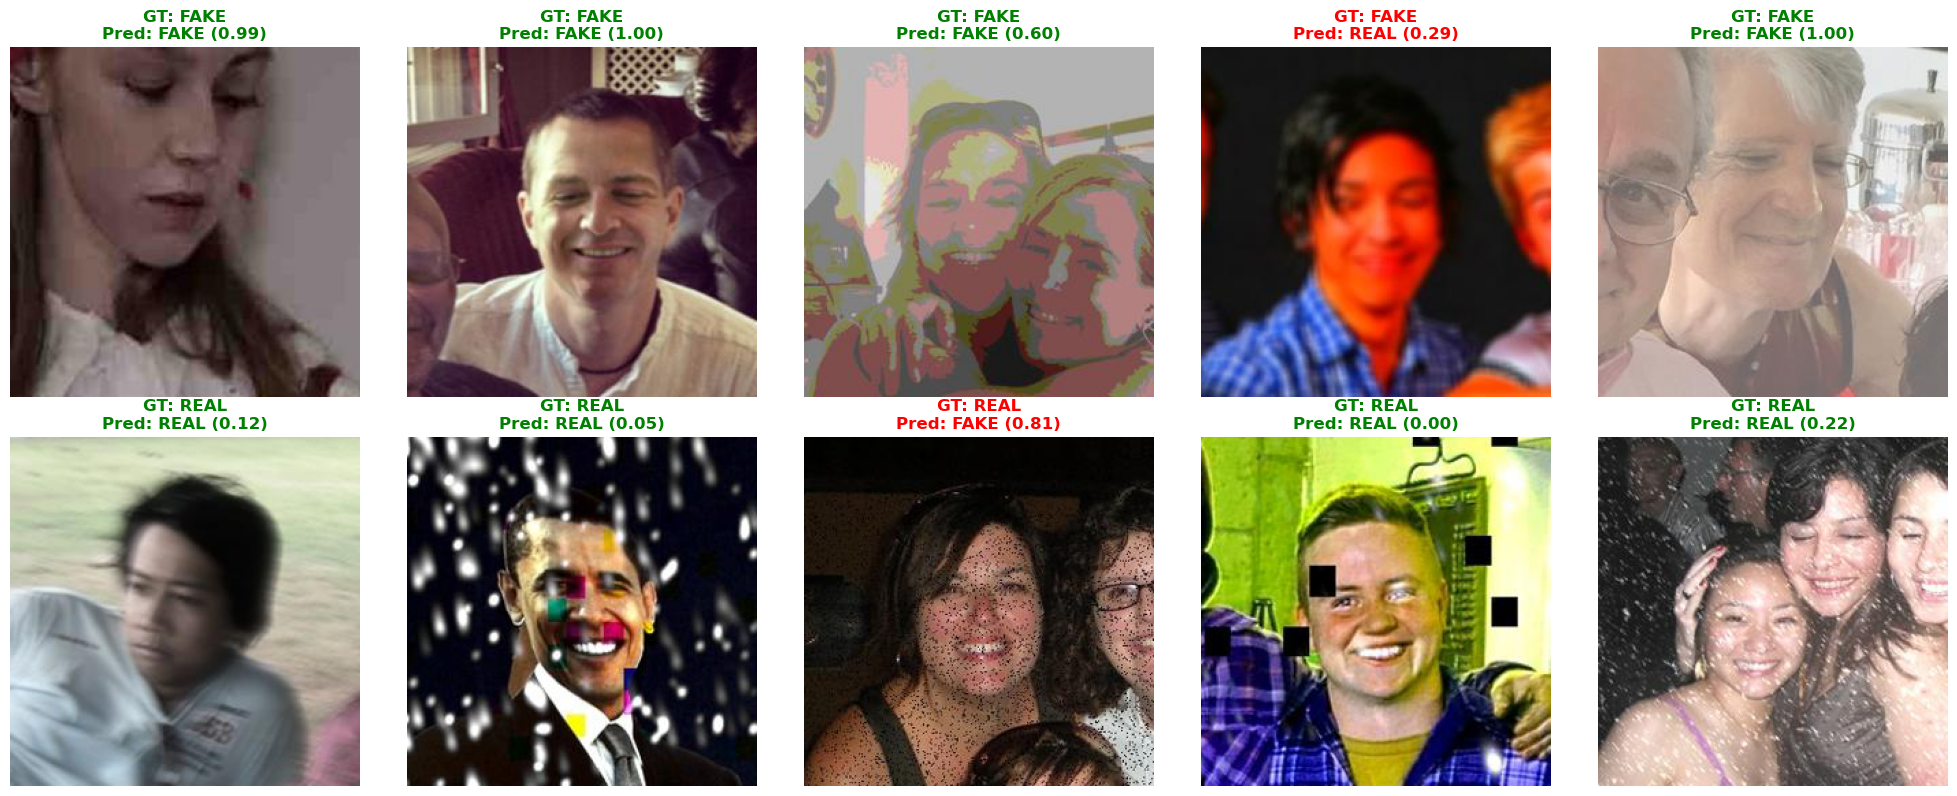

In [7]:
# 🧪 Test ensemble_finetuned_best.pth với 10 ảnh ngẫu nhiên
import torch, random, numpy as np
from pathlib import Path
from PIL import Image
from torchvision import transforms
from models import MetaLearnerMLP
from feature_extractor_finetuned import FinetunedXceptionFeatureExtractor, FinetunedEfficientNetB3FeatureExtractor
import matplotlib.pyplot as plt

# Load checkpoint & models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = torch.load('ensemble_finetuned_best.pth', map_location=device, weights_only=False)


xcp = FinetunedXceptionFeatureExtractor(ckpt['xception_ckpt']).to(device).eval()
eff = FinetunedEfficientNetB3FeatureExtractor(ckpt['efficientnet_ckpt']).to(device).eval()
mlp = MetaLearnerMLP(input_dim=ckpt['input_dim']).to(device)
mlp.load_state_dict(ckpt['model_state_dict'])
mlp.eval()

# Lấy 5 fake + 5 real
test_dir = Path('../Dataset/test')
test_imgs = random.sample(list((test_dir/'fake').glob('*.jpg')), 5) + \
            random.sample(list((test_dir/'real').glob('*.jpg')), 5)
label_names = ['FAKE']*5 + ['REAL']*5

# Transform
tfm = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Extract features & Predict
features, probs = [], []
with torch.no_grad():
    for img_path in test_imgs:
        img = tfm(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
        f = np.hstack([xcp(img).cpu().numpy(), eff(img).cpu().numpy()])
        features.append(f)

# Normalize, Select & Predict
X = np.vstack(features)
X = ckpt['scaler'].transform(X)[:, ckpt['selected_indices']]

with torch.no_grad():
    out = mlp(torch.FloatTensor(X).to(device))
    probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()

# Hiển thị
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, (img_path, true_label, prob) in enumerate(zip(test_imgs, label_names, probs)):
    pred = 'FAKE' if prob > 0.5 else 'REAL'
    
    img = Image.open(img_path)
    axes.flat[i].imshow(img)
    axes.flat[i].axis('off')
    
    color = 'green' if pred == true_label else 'red'
    axes.flat[i].set_title(f'GT: {true_label}\nPred: {pred} ({prob:.2f})', 
                           color=color, fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

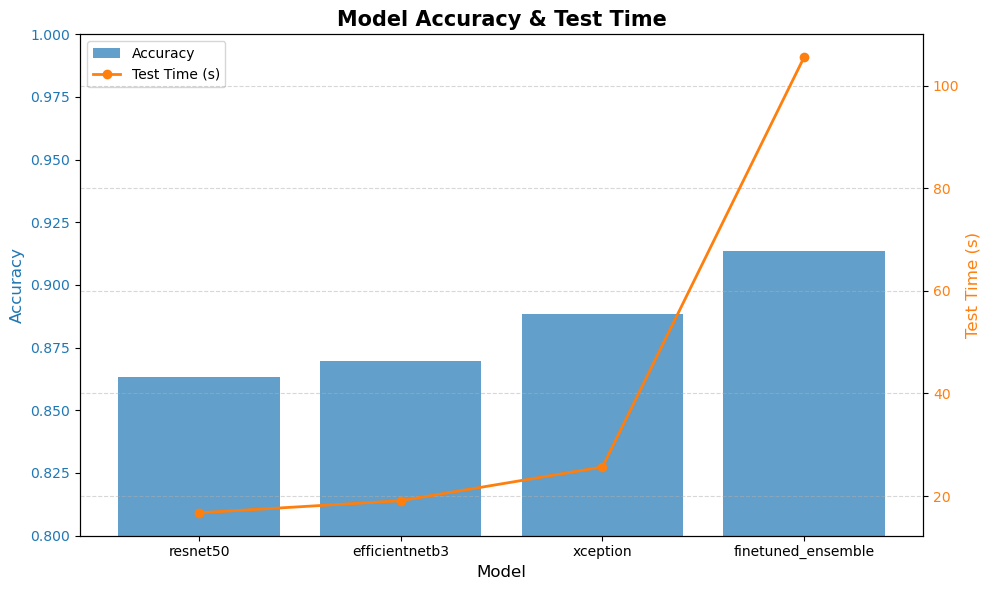

In [3]:
# Visualization: Accuracy & Test Time (Combined Chart)
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file kết quả
csv_path = '../src/test_results.csv'
df = pd.read_csv(csv_path)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Vẽ Accuracy (bar)
color_acc = 'tab:blue'
ax1.bar(df['Model'], df['Accuracy'], color=color_acc, alpha=0.7, label='Accuracy')
ax1.set_ylabel('Accuracy', color=color_acc, fontsize=12)
ax1.set_ylim(0.8, 1.0)
ax1.tick_params(axis='y', labelcolor=color_acc)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_title('Model Accuracy & Test Time', fontsize=15, fontweight='bold')

# Vẽ Test Time (line) trên trục phụ
ax2 = ax1.twinx()
color_time = 'tab:orange'
ax2.plot(df['Model'], df['Time (s)'], marker='o', color=color_time, linewidth=2, label='Test Time (s)')
ax2.set_ylabel('Test Time (s)', color=color_time, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color_time)

# Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()